# Customer Segmentation Project

## Project Overview

The goal is to carry out segmentation of customers using the transaction history of an online gift store occurring between 01/12/2010 and 09/12/2011.

## Project Scope

1. Connect to the database
2. Explore the data (SQL)
4. Data Preprocessing (Python)
5. Exploratory Data Analysis (Python - seaborn and matplotlib)
6. Segmentation by season (Python - seaborn and matplotlib, sklearn)
7. Segmentation by Country (Python - seaborn and matplotlib, sklearn)
8. Customer Segmentation using RFM and K means clustering

In [1]:
# Import libraries and packages
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style and palette
sns.set_style("whitegrid")
palette = sns.color_palette("husl", as_cmap=True)

## 1. Connect to sqlite

Connect to the sql database which contains the tables:

- online_transactions
- stock_description
- online_transactions_cleaned

In [3]:
conn = sqlite3.connect("../data/bootcamp_db")
conn

In [4]:
sql_query = """SELECT name
                FROM sqlite_master 
               WHERE type='table';"""

cursor = conn.cursor()

# executing our sql query
cursor.execute(sql_query)

 
# printing all tables list
print(f"List of tables in the database:\n{cursor.fetchall()}")

List of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]


In [5]:
query = """
select *
from online_transactions_cleaned;
"""

In [6]:
online_trans = pd.read_sql(query, conn)
online_trans

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom
...,...,...,...,...,...,...,...,...,...
399836,581580,22698,PINK REGENCY TEACUP AND SAUCER,2011-12-09 12:20:00,2.95,1,2.95,u12748,United Kingdom
399837,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,2011-12-09 12:25:00,0.72,72,51.84,u13777,United Kingdom
399838,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,2011-12-09 12:31:00,1.95,12,23.40,u15804,United Kingdom
399839,581585,84692,BOX OF 24 COCKTAIL PARASOLS,2011-12-09 12:31:00,0.42,25,10.50,u15804,United Kingdom


The dataset is the output of the ETL Pipeline project where the raw online transactions data was extracted , transformed and loaded to S3 cloud object. It contains 399841 transaction records from 01/12/2010 to 09/12/2011. The data has 9 attributes:
- invoice
- stock_code
- description
- price
- quantity
- total_order_value
- invoice_date
- customer_id
- country

## 2. Explore the Data
- Explore the data using SQL queries

In [7]:
# How many rows are there in the data?

query = """
SELECT COUNT(*)
FROM online_transactions_cleaned;
"""

pd.read_sql(query, conn)

,COUNT(*)
0,399841


In [8]:
# 1. How many invoices does the table contain?

query = """
SELECT COUNT(DISTINCT invoice) as invoice_count
FROM online_transactions_cleaned
where invoice IS NOT NULL;
"""
pd.read_sql(query, conn)

,invoice_count
0,21791


> Note: There are 399,841 rows and 21,791 invoices which means an invoice could have multiple lines or records.

In [9]:
# 2. When was the first and last purchase?

query = """
SELECT 
    MIN(invoice_date) as first_invoice_date,
    MAX(invoice_date) as last_invoice_date
FROM online_transactions_cleaned;
"""

pd.read_sql(query, conn)

,first_invoice_date,last_invoice_date
0,2010-12-01 08:26:00,2011-12-09 12:50:00


In [10]:
# 3. How many customers does the table contain?

query = """
SELECT COUNT(DISTINCT customer_id) as total_num_customers
FROM online_transactions_cleaned
"""

pd.read_sql(query, conn)

,total_num_customers
0,4363


In [11]:
# 4. How many different types of stocks did the customer purchase?

query = """
SELECT COUNT(DISTINCT stock_code) as total_num_stocks
FROM online_transactions_cleaned
"""

pd.read_sql(query, conn)

,total_num_stocks
0,3679


In [12]:
# 5. What is the most popular stock? (You can look at top 10 sold items - does this differ across markets?)

query = """
SELECT stock_code, description, SUM(quantity) as total_sold
FROM online_transactions_cleaned
GROUP BY stock_code, description
ORDER BY total_sold DESC
LIMIT 10
"""

pd.read_sql(query, conn)


,stock_code,description,total_sold
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53119
1,22197,POPCORN HOLDER,48689
2,85099B,JUMBO BAG RED RETROSPOT,44963
3,84879,ASSORTED COLOUR BIRD ORNAMENT,35215
4,85123A,CREAM HANGING HEART T-LIGHT HOLDER,34185
5,21212,PACK OF 72 RETROSPOT CAKE CASES,33386
6,23084,RABBIT NIGHT LIGHT,27045
7,22492,MINI PAINT SET VINTAGE,25880
8,22616,PACK OF 12 LONDON TISSUES,25305
9,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24129


In [13]:
# 6. What is the average order value i.e. price * quantity?

query = """
SELECT AVG(price * quantity) as average_order_value
FROM online_transactions_cleaned
"""

pd.read_sql(query, conn)

,average_order_value
0,20.716904


In [14]:
# 7. How many Stocks have the Description “Unknown”? 

query = """
SELECT COUNT(*) as unknown_stock_count
FROM online_transactions_cleaned
where description = 'Unknown'
"""

pd.read_sql(query,conn)

,unknown_stock_count
0,0


In [15]:
#8. # How many orders were placed per country?

query = """
SELECT
    country,
    COUNT(DISTINCT invoice) as num_invoices
FROM online_transactions_cleaned
GROUP BY country
ORDER BY num_invoices DESC
"""

pd.read_sql(query, conn)

,country,num_invoices
0,United Kingdom,19583
1,Germany,578
2,France,439
3,EIRE,313
4,Belgium,117
5,Spain,100
6,Netherlands,97
7,Australia,67
8,Switzerland,65
9,Portugal,55


In [16]:
# 9. # Preview data where quantity < 0 

query = """
SELECT *
FROM online_transactions_cleaned
WHERE quantity < 0
ORDER BY quantity 
LIMIT 10;
"""

pd.read_sql(query, conn)

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",2011-12-09 09:27:00,2.08,-80995,-168469.60,u16446,United Kingdom
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,2011-01-18 10:17:00,1.04,-74215,-77183.60,u12346,United Kingdom
2,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,2010-12-02 14:23:00,0.03,-9360,-280.80,u15838,United Kingdom
3,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,2011-04-18 13:08:00,2.10,-3114,-6539.40,u15749,United Kingdom
4,C550456,21175,GIN AND TONIC DIET METAL SIGN,2011-04-18 13:08:00,1.85,-2000,-3700.00,u15749,United Kingdom
5,C550456,85123A,CREAM HANGING HEART T-LIGHT HOLDER,2011-04-18 13:08:00,2.55,-1930,-4921.50,u15749,United Kingdom
6,C556522,22920,HERB MARKER BASIL,2011-06-13 11:21:00,0.55,-1515,-833.25,u16938,United Kingdom
7,C550456,47566B,TEA TIME PARTY BUNTING,2011-04-18 13:08:00,2.55,-1300,-3315.00,u15749,United Kingdom
8,C570556,20971,PINK BLUE FELT CRAFT TRINKET BOX,2011-10-11 11:10:00,1.06,-1296,-1373.76,u16029,United Kingdom
9,C569552,15034,PAPER POCKET TRAVELING FAN,2011-10-04 17:44:00,0.07,-1200,-84.00,u14533,United Kingdom


In [17]:
# 10. # How many invoices have negative quantities?

query = """
SELECT COUNT(DISTINCT invoice) as negative_quantities
FROM online_transactions_cleaned
WHERE quantity < 0
"""

pd.read_sql(query, conn)

,negative_quantities
0,3383


> Note: Out of 21,791 invoices 3,383 have negative quantities

## 3. Data Preprocessing

- Assess the data quality and structure and clean or transform it as necessary before performing further analysis, visualization, and segmentation of customers.

In [18]:
online_trans.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom


In [19]:
online_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   invoice            399841 non-null  object 
 1   stock_code         399841 non-null  object 
 2   description        399841 non-null  object 
 3   invoice_date       399841 non-null  object 
 4   price              399841 non-null  float64
 5   quantity           399841 non-null  int64  
 6   total_order_value  399841 non-null  float64
 7   customer_id        399841 non-null  object 
 8   country            399841 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 27.5+ MB


### Task 3.1: Converting the invoice data type from "object" to "datetime" data type

In [20]:
online_trans.invoice_date = pd.to_datetime(online_trans.invoice_date)
online_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            399841 non-null  object        
 1   stock_code         399841 non-null  object        
 2   description        399841 non-null  object        
 3   invoice_date       399841 non-null  datetime64[ns]
 4   price              399841 non-null  float64       
 5   quantity           399841 non-null  int64         
 6   total_order_value  399841 non-null  float64       
 7   customer_id        399841 non-null  object        
 8   country            399841 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.5+ MB


### Task 3.2: Checking for missing values and duplicate records

In [21]:
# Check for missing values

online_trans.isnull().sum()

invoice              0
stock_code           0
description          0
invoice_date         0
price                0
quantity             0
total_order_value    0
customer_id          0
country              0
dtype: int64

> Note: There are no missing values.

In [22]:
# Check for duplicate records

online_trans.duplicated().sum()

0

> Note: There is no duplicate records.

### Task 3.3: Investigate and handling the cancelled orders

In [23]:
# Investigate invoice numbers

online_trans['invoice'].str[0].value_counts()

invoice
5    391334
C      8507
Name: count, dtype: int64

In [24]:
online_trans[online_trans['invoice'].str[0] == 'C']

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
14,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,2010-12-01 10:24:00,1.65,-12,-19.80,u17548,United Kingdom
157,C536548,22631,CIRCUS PARADE LUNCH BOX,2010-12-01 14:33:00,1.95,-1,-1.95,u12472,Germany
227,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,2010-12-01 10:24:00,0.29,-24,-6.96,u17548,United Kingdom
408,C536820,22878,UNKNOWN,2010-12-02 17:14:00,2.10,-1,-2.10,u18168,United Kingdom
484,C536391,22553,PLASTERS IN TIN SKULLS,2010-12-01 10:24:00,1.65,-24,-39.60,u17548,United Kingdom
...,...,...,...,...,...,...,...,...,...
399654,C581235,22840,ROUND CAKE TIN VINTAGE RED,2011-12-08 10:34:00,7.95,-2,-15.90,u1595,United Kingdom
399677,C581316,21531,RED RETROSPOT SUGAR JAM BOWL,2011-12-08 11:46:00,2.55,-1,-2.55,u12523,France
399710,C581384,51008,AFGHAN SLIPPER SOCK PAIR,2011-12-08 13:06:00,3.45,-2,-6.90,u17673,United Kingdom
399711,C581390,23374,RED SPOT PAPER GIFT BAG,2011-12-08 13:13:00,0.82,-10,-8.20,u13081,United Kingdom


> Note: There are 8507 invoices that start with C which indicates cancellation.

In [25]:
# Find the canceled orders(negative quantity)
returns = online_trans[online_trans['quantity'] <= 0]
returns.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
14,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,2010-12-01 10:24:00,1.65,-12,-19.80,u17548,United Kingdom
157,C536548,22631,CIRCUS PARADE LUNCH BOX,2010-12-01 14:33:00,1.95,-1,-1.95,u12472,Germany
227,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,2010-12-01 10:24:00,0.29,-24,-6.96,u17548,United Kingdom
408,C536820,22878,UNKNOWN,2010-12-02 17:14:00,2.10,-1,-2.10,u18168,United Kingdom
484,C536391,22553,PLASTERS IN TIN SKULLS,2010-12-01 10:24:00,1.65,-24,-39.60,u17548,United Kingdom


In [26]:
# Match the canceled orders and their original orders
merged = online_trans.merge(returns, on=['customer_id','stock_code'], suffixes=('', '_return'))

In [27]:
# Check the number of rows and columns
merged.shape

(34639, 16)

In [28]:
# Check the result
merged.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country,invoice_return,description_return,invoice_date_return,price_return,quantity_return,total_order_value_return,country_return
0,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.3,u1785,United Kingdom,C543611,WOODEN FRAME ANTIQUE WHITE,2011-02-10 14:38:00,2.55,-2,-5.10,United Kingdom
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.3,u1785,United Kingdom,C543611,WOODEN FRAME ANTIQUE WHITE,2011-02-10 14:38:00,2.55,-12,-30.60,United Kingdom
2,536390,22960,JAM MAKING SET WITH JARS,2010-12-01 10:19:00,3.75,12,45.0,u17511,United Kingdom,C546854,JAM MAKING SET WITH JARS,2011-03-17 13:55:00,3.75,-1,-3.75,United Kingdom
3,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,2010-12-01 10:24:00,1.65,-12,-19.8,u17548,United Kingdom,C536391,PLASTERS IN TIN VINTAGE PAISLEY,2010-12-01 10:24:00,1.65,-12,-19.80,United Kingdom
4,536395,22727,ALARM CLOCK BAKELIKE RED,2010-12-01 10:47:00,3.75,8,30.0,u13767,United Kingdom,C543636,ALARM CLOCK BAKELIKE RED,2011-02-10 16:34:00,3.75,-1,-3.75,United Kingdom


In [29]:
# Calculate the total purchase quantity and the total return quantity
merged['total_quantity'] = merged['quantity'] + merged['quantity_return']

### Task 3.4 Filter and Refine Data

In [30]:
# Find the canceled orders and their original orders
complete_returns = merged[merged['total_quantity'] == 0]

In [31]:
# Check the number of rows and columns
complete_returns.shape[0]

5634

In [32]:
# Ensure that 'complete_returns' contains only the fields that need to be matched
complete_returns = complete_returns[[
    'invoice', 'stock_code', 'description', 'invoice_date', 
    'price', 'quantity', 'total_order_value', 'customer_id', 'country']]

In [33]:
# Remove these records from the original data
online_trans = online_trans.merge(complete_returns, on=[
    'invoice', 'stock_code', 'description', 'invoice_date', 
    'price', 'quantity', 'total_order_value', 'customer_id', 'country'
], how='left', indicator=True)

### Task 3.5: Clean up Data

In [34]:
# Keep only the rows that are not marked for deletion
online_trans = online_trans[online_trans['_merge'] == 'left_only']

In [35]:
# Remove auxiliary columns
online_trans = online_trans.drop(columns=['_merge'])

In [36]:
online_trans.shape

(394534, 9)

In [37]:
# Drop the other negative orders
online_trans_cleaned = online_trans[online_trans['quantity'] > 0]

In [38]:
# Check the number of records
len(online_trans_cleaned)

386027

#### **Note**
- "returns" is the DataFrame that has all the cancelled orders; "complete_returns" is the original order table for cancelled orders.

- "online_trans_cleaned" is now without cancelled orders and their original orders.

In [39]:
#online_trans_cleaned = online_trans[~online_trans['invoice'].str.startswith('C')]
#online_trans_cleaned

## 4. Exploratory Data Analysis

In [40]:
online_trans_cleaned.describe()

,invoice_date,price,quantity,total_order_value
count,386027,386027.000000,386027.000000,386027.000000
mean,2011-07-11 00:45:21.729516032,2.882029,12.629715,21.276502
min,2010-12-01 08:26:00,0.000000,1.000000,0.000000
25%,2011-04-07 11:59:00,1.250000,2.000000,4.950000
50%,2011-07-31 15:00:00,1.850000,6.000000,11.900000
75%,2011-10-20 14:13:00,3.750000,12.000000,19.800000
max,2011-12-09 12:50:00,1599.260000,12540.000000,7144.720000
std,NaN,7.086134,46.095694,66.546094


### 4.1: What are the top 10 countries in total sales

In [41]:
sales_by_country = online_trans_cleaned.groupby('country')['total_order_value'].sum().sort_values(ascending=False)
print(sales_by_country)

country
United Kingdom          6756342.413
Netherlands              282161.940
EIRE                     237641.810
Germany                  203089.880
France                   181031.390
Australia                136919.900
Spain                     51929.220
Switzerland               51859.300
Japan                     37212.370
Belgium                   36813.690
Sweden                    34616.330
Norway                    32179.180
Portugal                  26524.050
Channel Islands           20147.540
Finland                   18344.880
Denmark                   18081.240
Italy                     15457.190
Cyprus                    12744.560
Singapore                  9120.390
Austria                    8742.680
Israel                     7215.840
Poland                     6884.850
Greece                     4425.520
Iceland                    4310.000
Canada                     3115.440
Unspecified                2660.770
Malta                      2030.790
United Arab Emirates

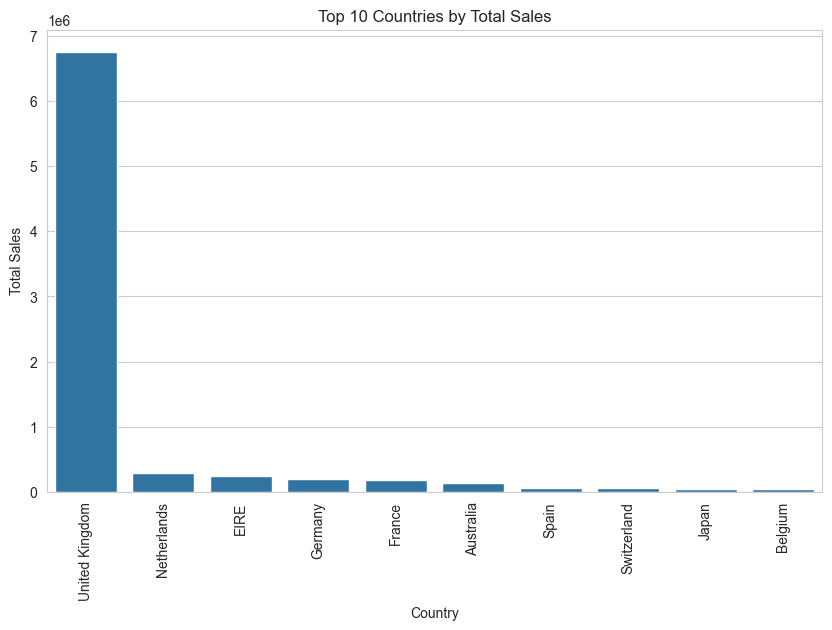

In [42]:
sales_by_country = online_trans_cleaned.groupby('country')['total_order_value'].sum().sort_values(ascending=False)[:10]
# Plot total sales by country
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_country.index, y=sales_by_country.values)
plt.xticks(rotation=90)
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.show()

### 2. What are the top 10 most popular products in terms of Total_sales?

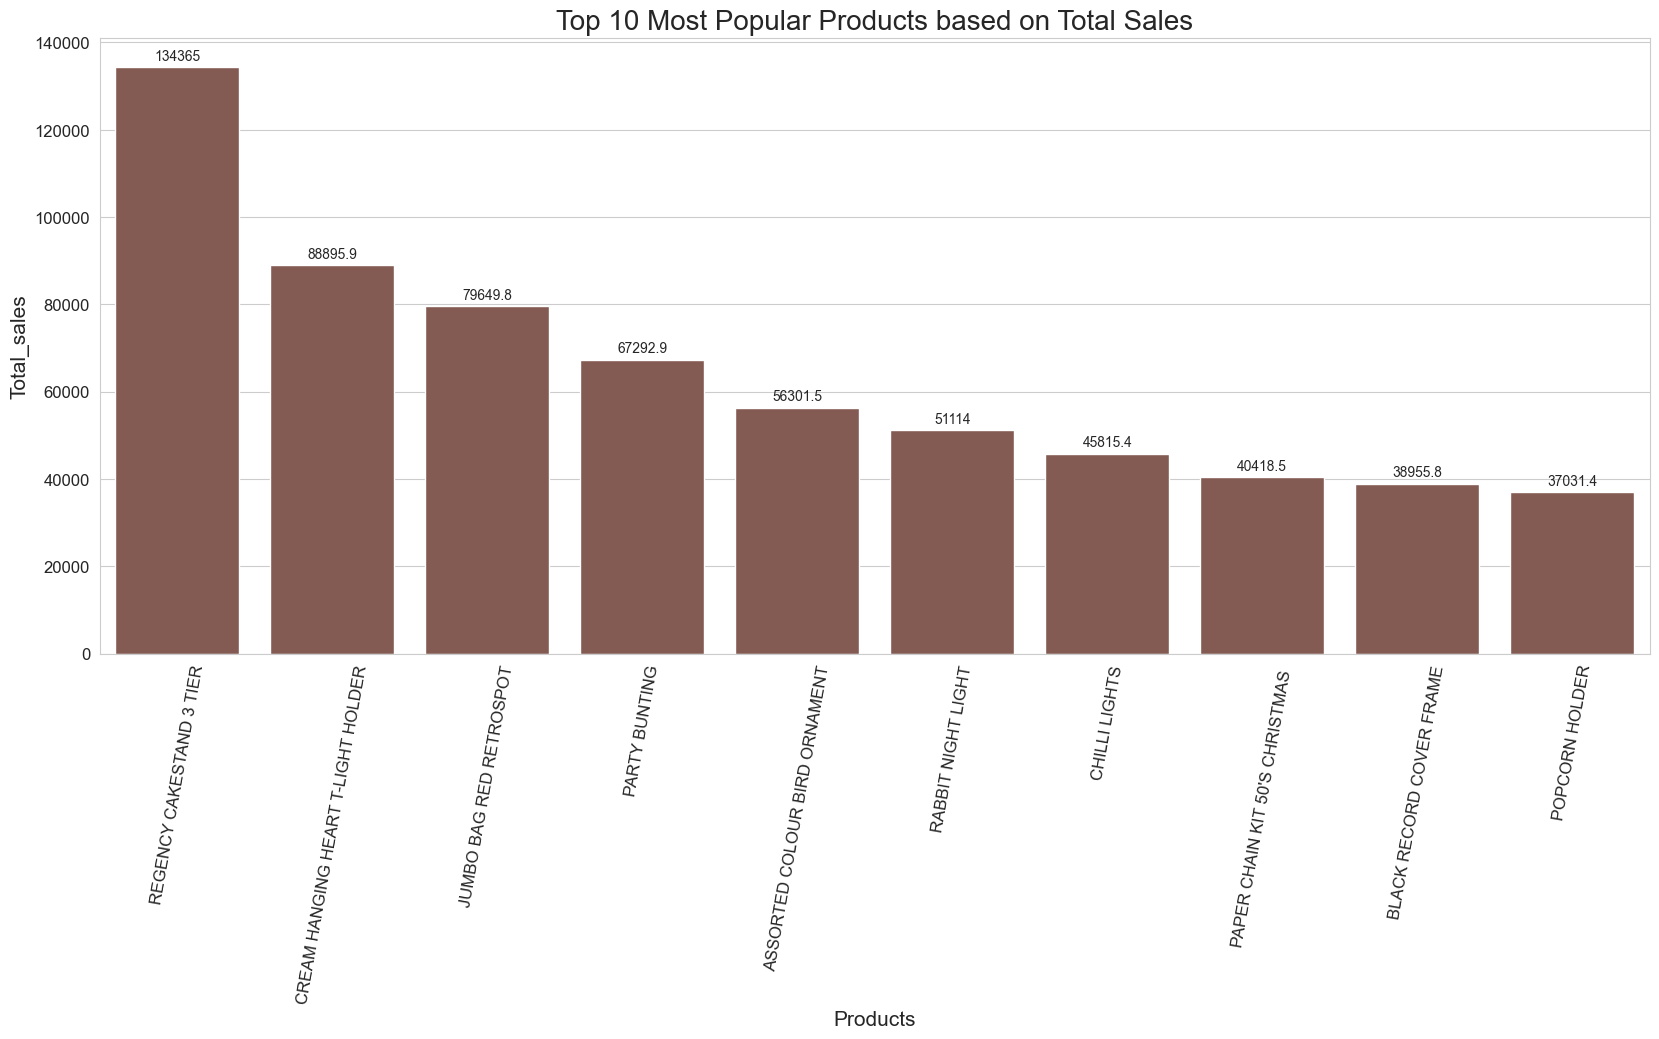

In [43]:
top10_prod = online_trans_cleaned.groupby(['description'])['total_order_value'].sum().sort_values(ascending=False)[:10]

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[5]

ax = sns.barplot(x = top10_prod.index, y = top10_prod.values, color = base_color)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3)
plt.xticks(rotation = 80)
plt.title('Top 10 Most Popular Products based on Total Sales', size = 20)
plt.xlabel('Products', size = 15)
plt.ylabel('Total_sales', size = 15)
plt.show;

### 3. who are the top 10 customers based on total sales?

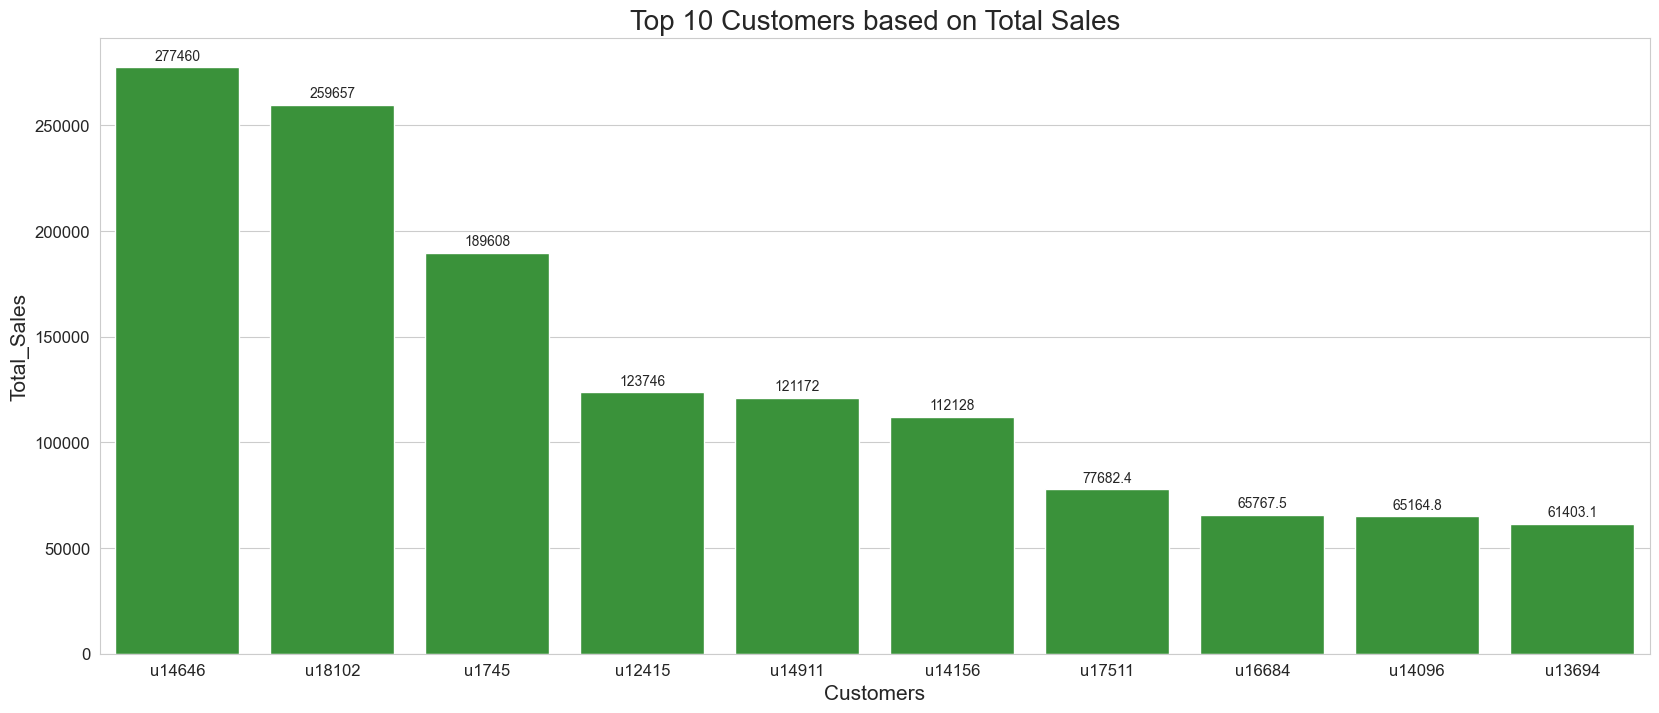

In [44]:
top10_cust = online_trans_cleaned.groupby(['customer_id'])['total_order_value'].sum().sort_values(ascending=False)[:10]

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[2]

ax = sns.barplot(x = top10_cust.index, y = top10_cust.values, color = base_color)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3)
plt.title('Top 10 Customers based on Total Sales', size = 20)
plt.xlabel('Customers', size = 15)
plt.ylabel('Total_Sales', size = 15)
plt.show;

### 4. What are the top 10 most popular products based on quantities sold?

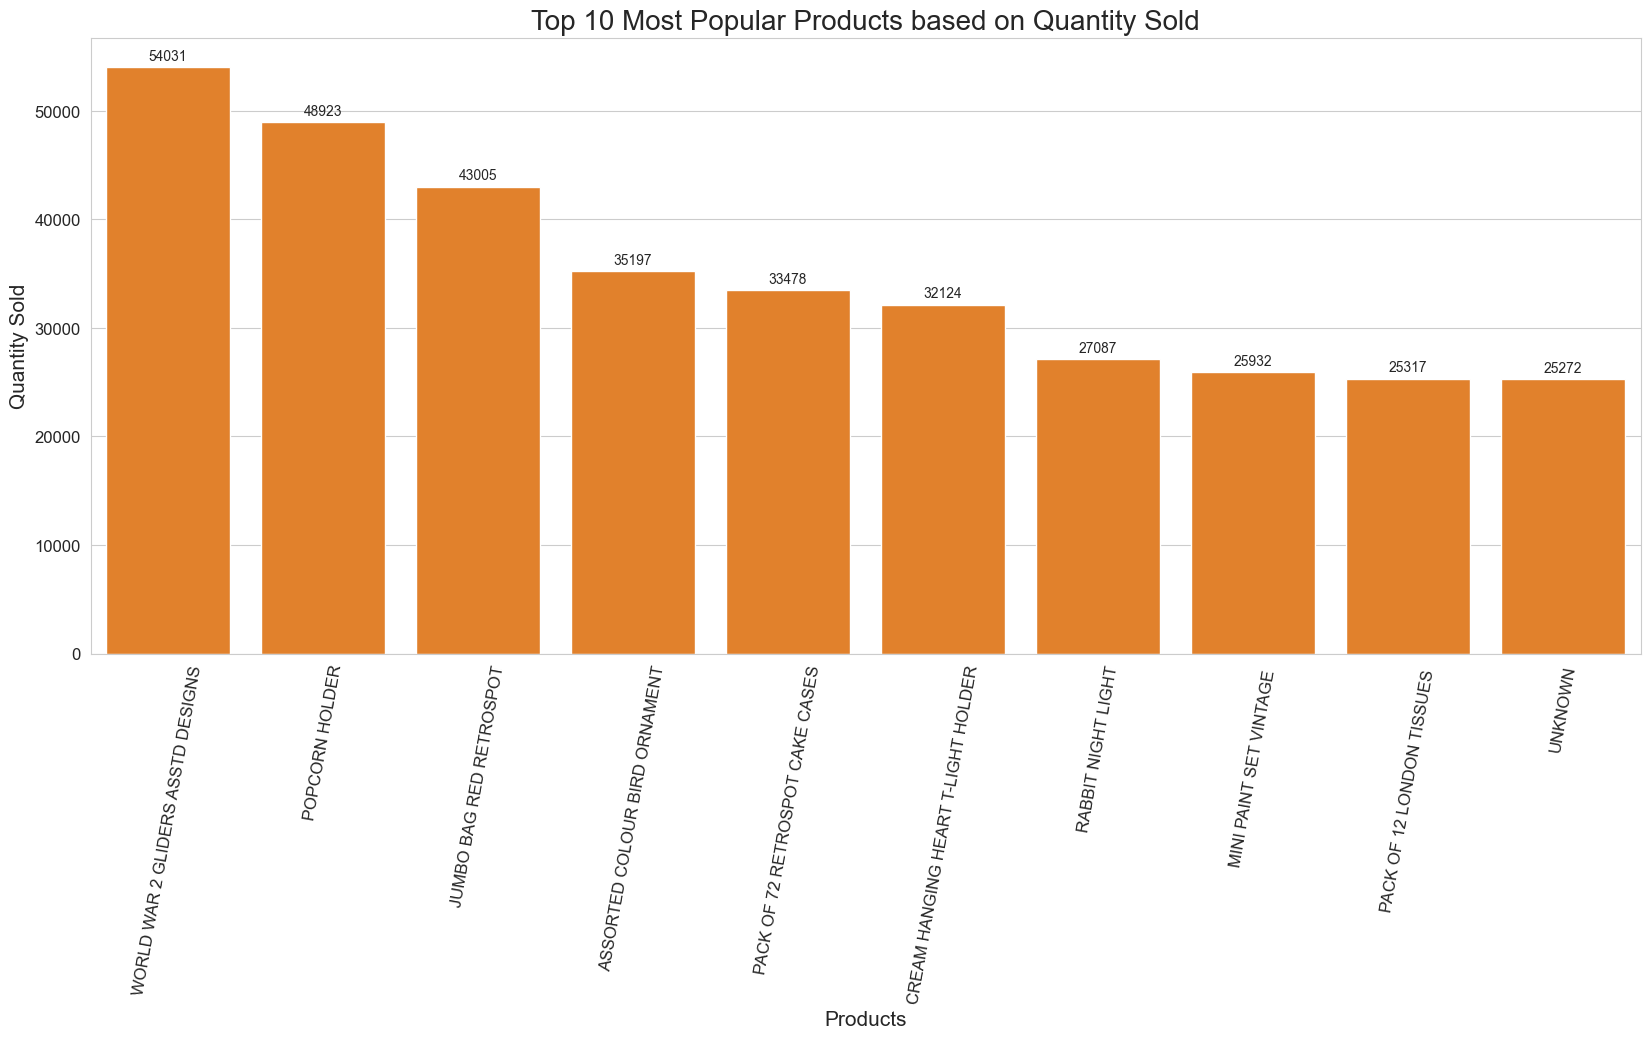

In [45]:
top10_prod_qty = online_trans_cleaned.groupby(['description'])['quantity'].sum().sort_values(ascending=False)[:10]

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[1]

ax = sns.barplot(x = top10_prod_qty.index, y = top10_prod_qty.values, color = base_color)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3)
plt.xticks(rotation = 80)
plt.title('Top 10 Most Popular Products based on Quantity Sold', size = 20)
plt.xlabel('Products', size = 15)
plt.ylabel('Quantity Sold', size = 15)
plt.show;

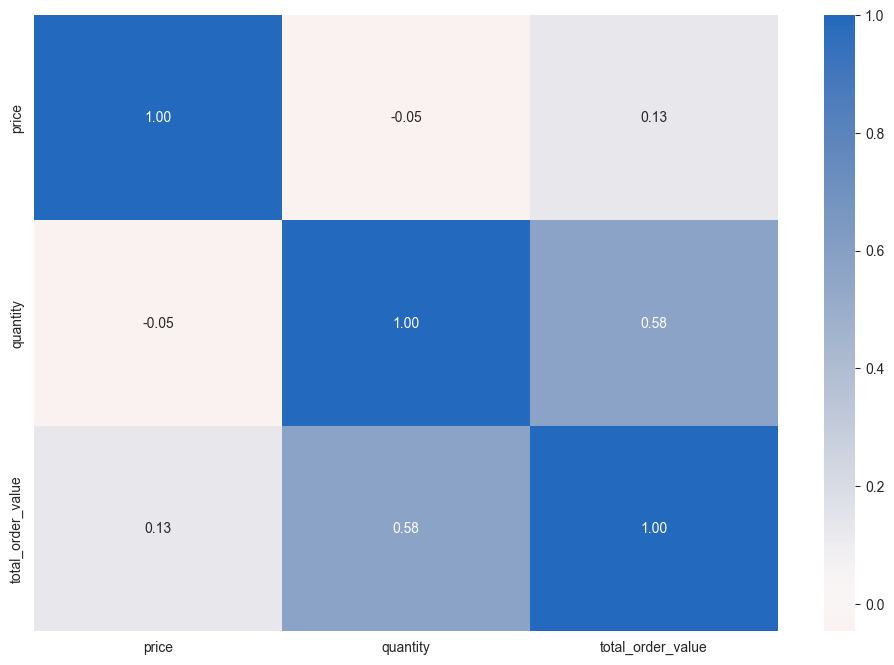

In [46]:
# Correlation plot between price, quantity and total order value

plt.figure(figsize = [12, 8])
sns.heatmap(online_trans_cleaned[['price', 'quantity', 'total_order_value']].corr(), annot = True, fmt = '.2f',
           cmap = 'vlag_r', center = 0)
plt.show()

#### Note

- There is a weak positive relationship 0.13 between price and total order value. It just means that high-priced product don't necessarily result to high sales amount.
- There is also a quite good relationship 0.58 between quantity and total order value. It suggests that larger quantities purchased can result to higher sales.
- There is a week negative relationship -0.05 between price and quantity. It's like high-priced products are purchased less than the low-priced products

## 5. Customer Segmentation by Season

###  Seasonality Analysis

#### 5.1: Distribution of Invoices per Month:

1. Visualize the distribution of invoices per month.
    - The bar chart displays the distribution of invoices across different months. This helps in understanding the seasonality of transactions.
2. Identify the month with the highest number of transactions.

In [47]:
online_trans_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386027 entries, 0 to 400167
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            386027 non-null  object        
 1   stock_code         386027 non-null  object        
 2   description        386027 non-null  object        
 3   invoice_date       386027 non-null  datetime64[ns]
 4   price              386027 non-null  float64       
 5   quantity           386027 non-null  int64         
 6   total_order_value  386027 non-null  float64       
 7   customer_id        386027 non-null  object        
 8   country            386027 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 29.5+ MB


In [48]:
# Extract month from invoice_date
online_trans_cleaned['month'] = online_trans_cleaned['invoice_date'].dt.month

In [49]:
# Distribution of invoices per month
invoices_per_month = online_trans_cleaned['month'].value_counts().sort_index()

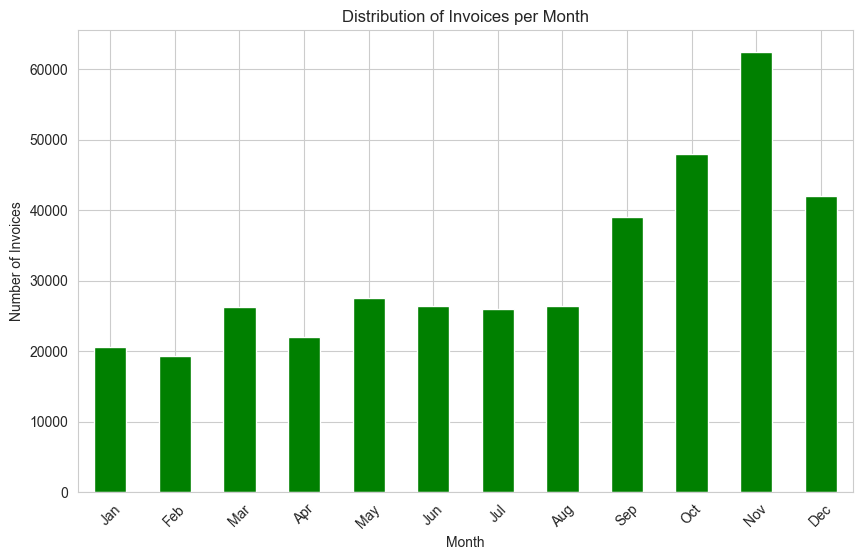

In [50]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
invoices_per_month.plot(kind='bar', color = 'green')
plt.title('Distribution of Invoices per Month')
plt.xlabel('Month')
plt.ylabel('Number of Invoices')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

### 5.2: Distribution of Invoices per Season

Visualize the distribution of invoices per season.
- The number of orders is relatively consistent across seasons Spring, Summer and Winter, with a markable increased during Autumn.

In [51]:
# Extract month and year from the invoice_date

online_trans_cleaned['month'] = online_trans_cleaned['invoice_date'].dt.month
online_trans_cleaned['year'] = online_trans_cleaned['invoice_date'].dt.year

In [52]:
# Define a function to determine the season from the month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [53]:
# Add a new column for season
online_trans_cleaned['season'] = online_trans_cleaned['month'].apply(get_season)

In [54]:
# Segmenting by season
season_segment = online_trans_cleaned.groupby('season').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('num_orders', ascending=False).reset_index()

In [55]:
season_segment

,season,num_orders,total_order_value
0,Autumn,6207,2991331.381
1,Winter,4095,1782948.440
2,Spring,3933,1640916.261
3,Summer,3932,1798108.181


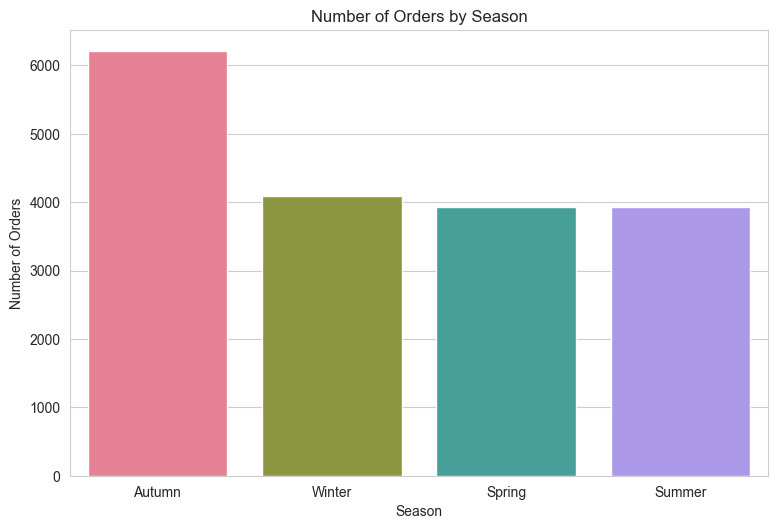

In [56]:
# Visualizations
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 3)
sns.barplot(x='season', y='num_orders', data=season_segment, palette='husl')
plt.title('Number of Orders by Season')
plt.xlabel('Season')
plt.ylabel('Number of Orders')

plt.tight_layout()
plt.show()

## 6. Customer Segmentation by Country

In [57]:
# creating segments based on the country

def create_customer_segments(i):
    if i == "United Kingdom":
        return "UK customer"
    else:
        return "Non-UK customer"

In [58]:
online_trans_cleaned['customer_segment']  = online_trans_cleaned.country.apply(create_customer_segments)

In [59]:
online_trans_cleaned.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country,month,year,season,customer_segment
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France,12,2010,Winter,Non-UK customer
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom,12,2010,Winter,UK customer
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom,12,2010,Winter,UK customer
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom,12,2010,Winter,UK customer
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom,12,2010,Winter,UK customer


In [60]:
# look at distribution of customers

online_trans_cleaned.customer_segment.value_counts()

customer_segment
UK customer        344535
Non-UK customer     41492
Name: count, dtype: int64

In [61]:
# can view as % instead of whole numbers 
online_trans_cleaned.customer_segment.value_counts(normalize=True)

customer_segment
UK customer        0.892515
Non-UK customer    0.107485
Name: proportion, dtype: float64

In [62]:
# look at the UK customer segment

uk_customers = online_trans_cleaned[online_trans_cleaned.customer_segment == "UK customer"]
uk_customers.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country,month,year,season,customer_segment
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom,12,2010,Winter,UK customer
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom,12,2010,Winter,UK customer
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom,12,2010,Winter,UK customer
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom,12,2010,Winter,UK customer
5,536381,22438,BALLOON ART MAKE YOUR OWN FLOWERS,2010-12-01 09:41:00,1.95,1,1.95,u15311,United Kingdom,12,2010,Winter,UK customer


In [63]:
uk_customers.describe()

,invoice_date,price,quantity,total_order_value,month,year
count,344535,344535.000000,344535.000000,344535.000000,344535.000000,344535.000000
mean,2011-07-11 10:23:25.752100864,2.873249,11.566053,19.610032,7.643557,2010.932907
min,2010-12-01 08:26:00,0.000000,1.000000,0.000000,1.000000,2010.000000
25%,2011-04-07 12:29:00,1.250000,2.000000,4.200000,5.000000,2011.000000
50%,2011-08-01 09:31:00,1.850000,4.000000,10.200000,9.000000,2011.000000
75%,2011-10-23 12:46:00,3.750000,12.000000,17.850000,11.000000,2011.000000
max,2011-12-09 12:49:00,1599.260000,12540.000000,7144.720000,12.000000,2011.000000
std,NaN,7.374627,45.656985,65.073315,3.415271,0.250184


In [64]:
## look at the Non-UK customer segment

non_uk_customers = online_trans_cleaned[online_trans_cleaned.customer_segment == "Non-UK customer"]
non_uk_customers.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country,month,year,season,customer_segment
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.0,u12583,France,12,2010,Winter,Non-UK customer
9,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,2010-12-01 10:03:00,5.45,6,32.7,u12431,Australia,12,2010,Winter,Non-UK customer
10,536389,22193,RED DINER WALL CLOCK,2010-12-01 10:03:00,8.50,2,17.0,u12431,Australia,12,2010,Winter,Non-UK customer
67,536527,22973,CHILDREN'S CIRCUS PARADE MUG,2010-12-01 13:04:00,1.65,12,19.8,u12662,Germany,12,2010,Winter,Non-UK customer
80,536370,22900,SET 2 TEA TOWELS I LOVE LONDON,2010-12-01 08:45:00,2.95,24,70.8,u12583,France,12,2010,Winter,Non-UK customer


In [65]:
# Segmenting by country
customer_segment = online_trans_cleaned.groupby('customer_segment').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('num_orders', ascending=False).reset_index()

In [66]:
customer_segment

,customer_segment,num_orders,total_order_value
0,UK customer,16378,6756342.413
1,Non-UK customer,1789,1456961.850


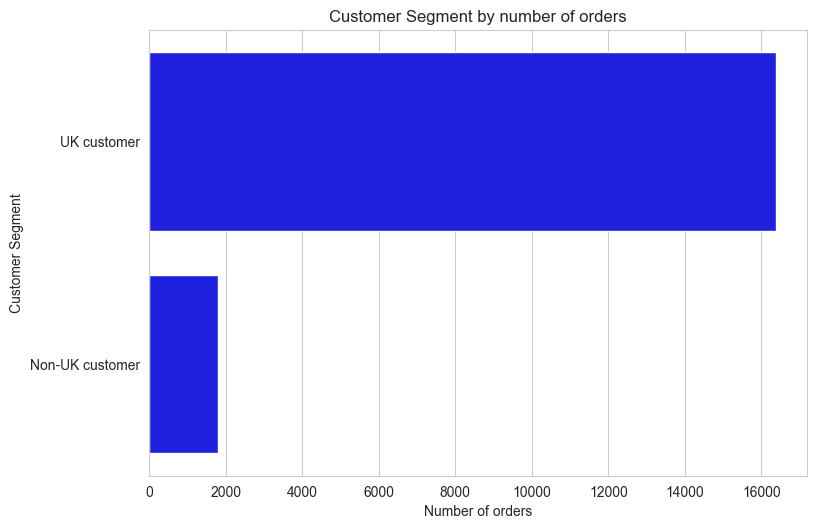

In [67]:
# Visualizations
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.barplot(x='num_orders', y='customer_segment', data=customer_segment.sort_values('num_orders', ascending=False), color = 'blue')
plt.title('Customer Segment by number of orders')
plt.xlabel('Number of orders')
plt.ylabel('Customer Segment')

plt.tight_layout()
plt.show()

> **Note**: From the above segmentation, we can clearly say that UK Customers are purchasing more compared to the other countries.

## 7. Customer Segmentation using RFM

- Using RFM (Recency, Frequency, Monetary) analysis to segment customers:

In [68]:
import datetime as dt

In [69]:
# Define snapshot date for recency calculation
snapshot_date = online_trans_cleaned['invoice_date'].max() + dt.timedelta(days=1)

In [88]:
# RFM analysis
rfm = online_trans_cleaned.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days,
    'invoice': 'nunique',
    'total_order_value': 'sum'
}).rename(columns={
    'invoice_date': 'Recency',
    'invoice': 'Frequency',
    'total_order_value': 'Monetary'
}).reset_index()

In [89]:
# Rename columns to Recency, Frequency, Monetary
rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

In [90]:
# Inspect the RFM dataframe
rfm.head()

,customer_id,Recency,Frequency,Monetary
0,u12347,2,7,4310.00
1,u12348,75,4,1437.24
2,u12349,19,1,1457.55
3,u1235,310,1,294.40
4,u12352,36,5,1125.28


#### Description:

I have created a "total_order_value" feature by multiplying Quantity and Price. We then calculated Recency, Frequency, and Monetary features for each customer:

- **Recency**: Number of days since the last purchase.
- **Frequency**: Number of transactions.
- **Monetary**: Total money spent.

In [95]:
# KMeans clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [96]:
# Log transform the Monetary feature to reduce skewness
rfm['Monetary'] = np.log1p(rfm['Monetary'])

In [94]:
# Scaling the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [97]:
# Convert to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled.head()

,Recency,Frequency,Monetary
0,-0.906770,0.372230,1.450048
1,-0.179662,-0.027070,0.571202
2,-0.737444,-0.426369,0.582428
3,2.161027,-0.426369,-0.696006
4,-0.568117,0.106030,0.375458


> **Preprocessing**: 
We log-transformed the Monetary feature to reduce skewness, then scaled the Recency, Frequency, and Monetary features using StandardScaler.

In [98]:
# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("RFM DataFrame with Clusters:")
print(rfm.head())

RFM DataFrame with Clusters:
  customer_id  Recency  Frequency  Monetary  Cluster
0      u12347        2          7  2.237398        1
1      u12348       75          4  2.112777        1
2      u12349       19          1  2.114471        0
3       u1235      310          1  1.900364        3
4      u12352       36          5  2.082770        0


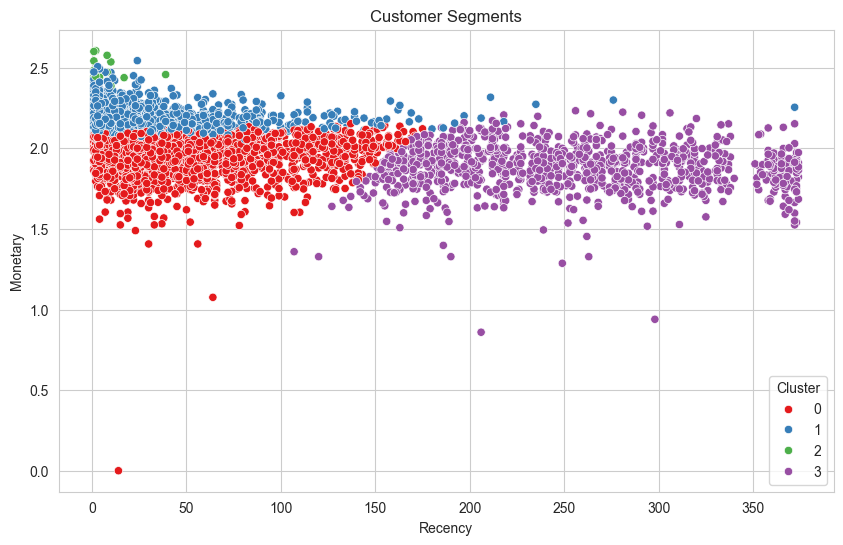

In [99]:
# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1')
plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [103]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [104]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

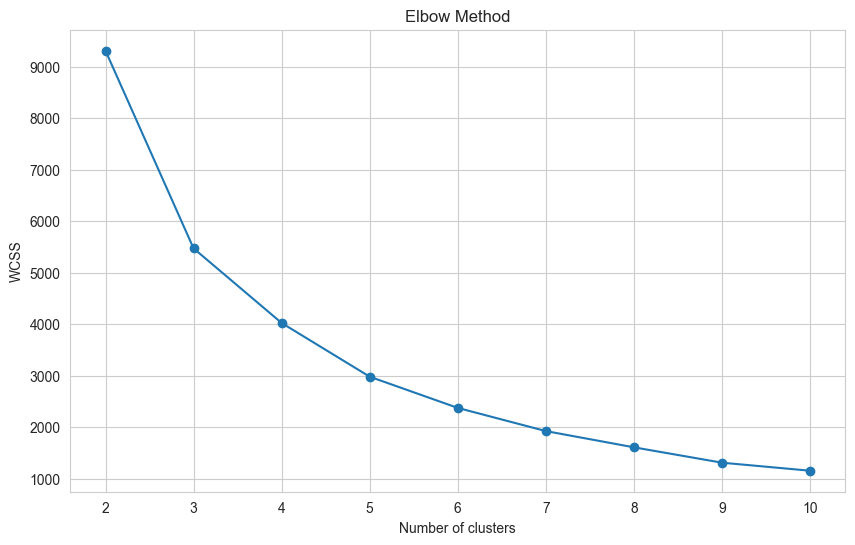

In [79]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [80]:
# Fit the KMeans model with the optimal number of clusters
optimal_clusters = 4  # Assume the elbow suggests 4 clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [81]:
# Silhouette score
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.6161541279102379


#### Description:

- **K-Means Clustering**: We used the elbow method to determine the optimal number of clusters. The silhouette score is used to evaluate how well clusters are separated.

### 7.1: Analyzing the Clusters

In [105]:
# Analysis and Interpretation
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_id': 'count' 
}).reset_index()


In [106]:
# Rename CustomerID count to CustomerCount
cluster_analysis.columns = ['Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'CustomerCount']

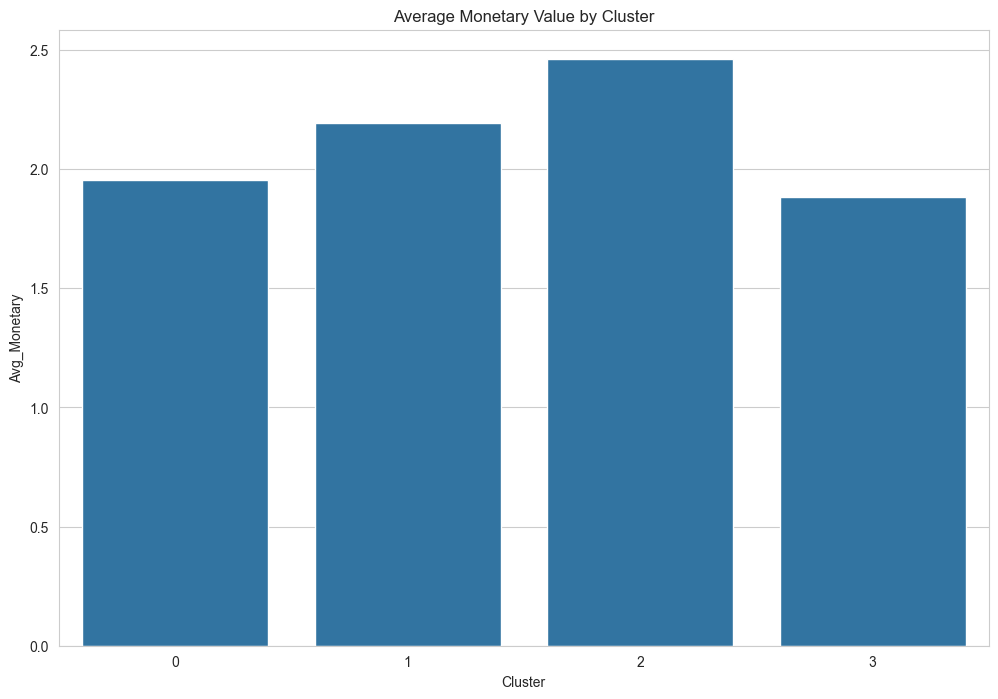

,Cluster,Avg_Recency,Avg_Frequency,Avg_Monetary,CustomerCount
0,0,52.866341,2.181463,1.955218,2050
1,1,30.025806,8.561290,2.193063,1240
2,2,6.000000,77.047619,2.461433,21
3,3,253.585559,1.445104,1.881247,1011


In [108]:
# Visualize the cluster characteristics
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Avg_Monetary', data=cluster_analysis)
plt.title('Average Monetary Value by Cluster')
plt.show()

cluster_analysis

#### Description:

- **Cluster Analysis**: We analyzed the average **Recency, Frequency,** and **Monetary** values for each cluster. Visualization using bar plots helps interpret the segmentation results.

## Conclusion

In this project, I have segmented customers based on
- **Seasonality** : To know in which season customers are purchasing more.
- **Country**: To know from which country the customers are purchasing more.
- **Purchasing behavior using the RFM model and K-Means clustering**: The results identified distinct customer groups with different purchasing patterns, which can be leveraged for targeted marketing strategies.

This project showcases the complete process of customer segmentation using an online_transactions_cleaned dataset. 
